# LSTM básico para etiquetado de secuencias

En este tutorial vamos a explorar la creación de un etiquetador con LSTMs. Vamos a procesar una frase con una etiquetas que llamamos "partes del habla" (Part of Speech), lo cuál no es nada mas que etiquetas con funciones gramaticales de cada palabra. 

Para ello vamos a usar la biblioteca keras, que en tensorflow ya es parte de esta. 

In [1]:
import tensorflow.keras as keras

### Preparar los datos

Ahora vamos a importar la base de datos con la que vemos a trabajar. Para ello usamos la biblioteca NLTK.

In [2]:
import nltk
nltk.download("treebank")
nltk.download("universal_tagset")

[nltk_data] Downloading package treebank to /Users/jm/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/jm/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

Ahora que ya tenemos instalados los datos vamos a cargar los datos a nuestro programa. Para poder ver los datos y entender su funcionamiento imprimiremos los mismos.

In [3]:
from nltk.corpus import treebank

sentences = treebank.tagged_sents(tagset="universal")
print(sentences[0])
print(len(sentences))

[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]
3914


Ahora vamos a separar las palabras de los tags.

In [4]:
sentences_data = list()
tags_data = list()

# Separando tags de palabras
for sentence in sentences:
    s, t = zip(*sentence)
    sentences_data.append(s)
    tags_data.append(t)
    
print(sentences_data[0])
print(tags_data[0])

('Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.')
('NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.')


Para separar los datos vamos a usar la biblioteca sklearn.  Lo vamos a hacer en tres partes. Uno para entrenar el modelo, otro para ajustar nuestros hiperparámetros y un último para probar nuestro modelo.Esta nos permite realizar la operación de manera automática.

In [5]:
from sklearn.model_selection import train_test_split

# Dividir los datos en tres conjuntos: train, dev y test

train_sent, test_sent, train_tags, test_tags = train_test_split(sentences_data, tags_data, test_size=0.2)
train_sent, dev_sent, train_tags, dev_tags = train_test_split(train_sent, train_tags, test_size=0.1)

# Hacer una lista de todos los tags y de todas las palabras vistas en el conjunto de entrenamiento

uniq_tags = list()
uniq_words = list()

for sent,tags in zip(train_sent, train_tags):
    for word, tag in zip(sent, tags):
        uniq_tags.append(tag)
        uniq_words.append(word)

uniq_tags = list(set(uniq_tags))
uniq_words = list(set(uniq_words))
    
print(uniq_tags)
print(uniq_words)

['DET', 'PRT', 'X', 'VERB', 'NUM', 'NOUN', 'ADJ', 'CONJ', '.', 'ADP', 'PRON', 'ADV']
['numbers', 'jockeys', 'absolutely', 'Pickens', 'philosophy', 'reached', 'grower', 'takings', 'doubts', 'coke', 'vindication', 'likelihood', 'thread', 'place', '2.19', 'Scypher', 'boomers', 'handle', 'evening', 'inquiry', 'Waste', '32', 'Labor', '300-113', 'burdens', 'exceed', 'generous', 'remains', 'travelers', 'demand', 'Baker', 'Cheetham', '64.5', 'appreciation', 'opinion', 'English', 'merge', 'welcomed', 'hold', 'range', 'son', 'Rather', 'Corp.', 'airline', 'scared', 'Miami-based', 'denouncing', 'anxieties', 'Army', 'indexes', 'lucky', 'Messrs.', 'notably', 'alcoholism', 'areas', 'roll', 'chunk', 'all-cash', 'toll', 'constraints', 'Joe', 'touched', '28.4', 'frequency', 'veal', 'Milne', 'exerting', 'Higher', 'Mindy', 'apology', 'Hammond', 'scenic', 'order', 'Highway', 'Safety', '3,600', 'workable', 'makers', 'paperback', '*-97', 'Management', 'persistent', 'serve', 'spot', 'pegged', 'Basham', 'under

Una vez que tenemos el dataset partido debidamente vamos a comprobar que sean del tamaño deseado y que contengan lo que esperamos.

In [6]:
print("Train len:", len(train_sent), "Dev len", len(dev_sent), "Test len", len(test_sent))
print(train_sent[0])
print(train_tags[0])

Train len: 2817 Dev len 314 Test len 783
('Says', '*ICH*-1', 'Kathryn', 'McAuley', ',', 'an', 'analyst', 'at', 'First', 'Manhattan', 'Co.', ':', '``', 'This', 'is', 'the', 'greatest', 'acquisition', 'challenge', '0', 'he', 'has', 'faced', '*T*-2', '.')
('VERB', 'X', 'NOUN', 'NOUN', '.', 'DET', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'NOUN', '.', '.', 'DET', 'VERB', 'DET', 'ADJ', 'NOUN', 'NOUN', 'X', 'PRON', 'VERB', 'VERB', 'X', '.')


Una vez teniendo separados nuestros datasets, es tiempo de convertir los en números enteros, lo cuál nos va a permitir trabajar con ellos en una red neronal. 

In [7]:

word_to_indx = {"PAD":0,"OOV":1, "BOS":2, "EOS":3}
indx_to_word = {0:"PAD",1:"OOV", 2:"BOS", 3:"EOS"}


tag_to_indx = {"PAD":0, "OOV":1, "BOS":2, "EOS":3}
indx_to_tag = {0:"PAD", 1:"OOV", 2:"BOS", 3:"EOS"}

for line in train_sent:
    for word in line:
        if not word in word_to_indx.keys():
            word_to_indx[word] = len(word_to_indx)
            indx_to_word[len(word_to_indx)-1] = word
    
for line in train_tags:
    for tag in line:
        if not tag in tag_to_indx.keys():
            tag_to_indx[tag] = len(tag_to_indx)
            indx_to_tag[len(tag_to_indx)-1] = tag

print(tag_to_indx)
print(indx_to_tag)

{'PAD': 0, 'OOV': 1, 'BOS': 2, 'EOS': 3, 'VERB': 4, 'X': 5, 'NOUN': 6, '.': 7, 'DET': 8, 'ADP': 9, 'ADJ': 10, 'PRON': 11, 'NUM': 12, 'ADV': 13, 'PRT': 14, 'CONJ': 15}
{0: 'PAD', 1: 'OOV', 2: 'BOS', 3: 'EOS', 4: 'VERB', 5: 'X', 6: 'NOUN', 7: '.', 8: 'DET', 9: 'ADP', 10: 'ADJ', 11: 'PRON', 12: 'NUM', 13: 'ADV', 14: 'PRT', 15: 'CONJ'}


Es hora de convertir todas las frases en valores enteros. Esto lo realizaremos con nuestros índices que creamos arriba.

In [8]:
def sent_to_int(sent):
    int_sent = list()
    for word in sent:
        if word in word_to_indx.keys():
            int_sent.append(word_to_indx[word])
        else:
            int_sent.append(word_to_indx["OOV"])
    return int_sent

def tag_to_int(sent):
    int_sent = list()
    for tag in sent:
        if tag in tag_to_indx.keys():
            int_sent.append(tag_to_indx[tag])
        else:
            int_sent.append(tag_to_indx["OOV"])
    return int_sent

train_X, dev_X, train_Y, dev_Y, test_X, test_Y = list(), list(), list(), list(), list(), list()

for lineX, lineY in zip(train_sent, train_tags):
    train_X.append(sent_to_int(lineX))
    train_Y.append(tag_to_int(lineY))

for lineX, lineY in zip(dev_sent, dev_tags):
    dev_X.append(sent_to_int(lineX))
    dev_Y.append(tag_to_int(lineY))

for lineX, lineY in zip(test_sent, test_tags):
    test_X.append(sent_to_int(lineX))
    test_Y.append(tag_to_int(lineY))
    
print(len(train_X[100]))
print(len(train_Y[100]))

29
29


Para poder trabajar con datos secuenciales desde keras, será necesario que todas las frases tengan el mismo tamaño. Para ello vamos a llenar los espacios vacíos de cada frase con un símbolo de PAD. Este valor es 0, y está acorde a lo que definimos anteriormente.

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LENGTH = len(max(train_X, key=len))
train_X = pad_sequences(maxlen=MAX_LENGTH, sequences=train_X, padding="post")
train_Y = pad_sequences(maxlen=MAX_LENGTH, sequences=train_Y, padding="post")
dev_X = pad_sequences(maxlen=MAX_LENGTH, sequences=dev_X, padding="post")
dev_Y = pad_sequences(maxlen=MAX_LENGTH, sequences=dev_Y, padding="post")
test_X = pad_sequences(maxlen=MAX_LENGTH, sequences=test_X, padding="post")
test_Y = pad_sequences(maxlen=MAX_LENGTH, sequences=test_Y, padding="post")

print(len(train_Y))
print(len(train_X[0]))
print(train_X[0])

2817
271
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0]


Las salidas de cada etiqueta es categórica. Por lo que debemos de ajustar los datos de todas las Y a valores categógicos.

In [10]:
from tensorflow.keras.utils import to_categorical

train_cat_Y = [to_categorical(i, num_classes=len(tag_to_indx)) for i in train_Y]
dev_cat_Y = [to_categorical(i, num_classes=len(tag_to_indx)) for i in dev_Y]
test_cat_Y = [to_categorical(i, num_classes=len(tag_to_indx)) for i in test_Y]

print("Cantidad de etiquetas:", len(tag_to_indx))
print("Cantidad de ejemplos en train:", len(train_cat_Y))
print("Cantidad de tokens por ejemplo:",len(train_cat_Y[0]))
print("Tamaño de los vectores en y:", len(train_cat_Y[0][0]))
print(train_cat_Y[0])

Cantidad de etiquetas: 16
Cantidad de ejemplos en train: 2817
Cantidad de tokens por ejemplo: 271
Tamaño de los vectores en y: 16
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


### Definir el modelo LSTM

Es hora de definir el modelo y generar los embeddings para que nuestros datos puedan ser usados en la red neuronal.

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional


input = keras.Input(shape=(MAX_LENGTH,))
model = Embedding(input_dim=len(word_to_indx), output_dim=50, input_length=MAX_LENGTH)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(len(tag_to_indx), activation="softmax"))(model)  # softmax output layer

In [12]:
model = Model(input, out)

In [13]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 271)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 271, 50)           515100    
_________________________________________________________________
dropout (Dropout)            (None, 271, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 271, 200)          120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 271, 16)           3216      
Total params: 639,116
Trainable params: 639,116
Non-trainable params: 0
_________________________________________________________________


In [14]:
import numpy as np
print(len(train_X[0]), len(train_X))
print(len(train_cat_Y[0]), len(train_cat_Y))

history = model.fit(train_X, np.array(train_cat_Y), batch_size=32, epochs=5, validation_data=[dev_X, np.array(dev_cat_Y)], verbose=1)

271 2817
271 2817


W0628 06:31:10.134824 140735769576384 deprecation.py:323] From /Users/jm/miniconda3/envs/escueladl/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2817 samples, validate on 314 samples
Epoch 1/5
2817/2817 [==============================] - 38s 13ms/sample - loss: 0.3466 - accuracy: 0.9123 - val_loss: 0.2300 - val_accuracy: 0.9271
Epoch 2/5
2817/2817 [==============================] - 37s 13ms/sample - loss: 0.1970 - accuracy: 0.9362 - val_loss: 0.1727 - val_accuracy: 0.9477
Epoch 3/5
2817/2817 [==============================] - 35s 12ms/sample - loss: 0.1140 - accuracy: 0.9679 - val_loss: 0.0766 - val_accuracy: 0.9769
Epoch 4/5
2817/2817 [==============================] - 34s 12ms/sample - loss: 0.0488 - accuracy: 0.9863 - val_loss: 0.0380 - val_accuracy: 0.9894
Epoch 5/5
2817/2817 [==============================] - 34s 12ms/sample - loss: 0.0238 - accuracy: 0.9934 - val_loss: 0.0300 - val_accuracy: 0.9902


# Resultados

Veamos como se comportó nuestro modelo a travéz de las épocas de entrenamiento. Vemos tanto el accuracy sobre el conjunto de entrenamiento, así como también sobre el conjunto de validación.

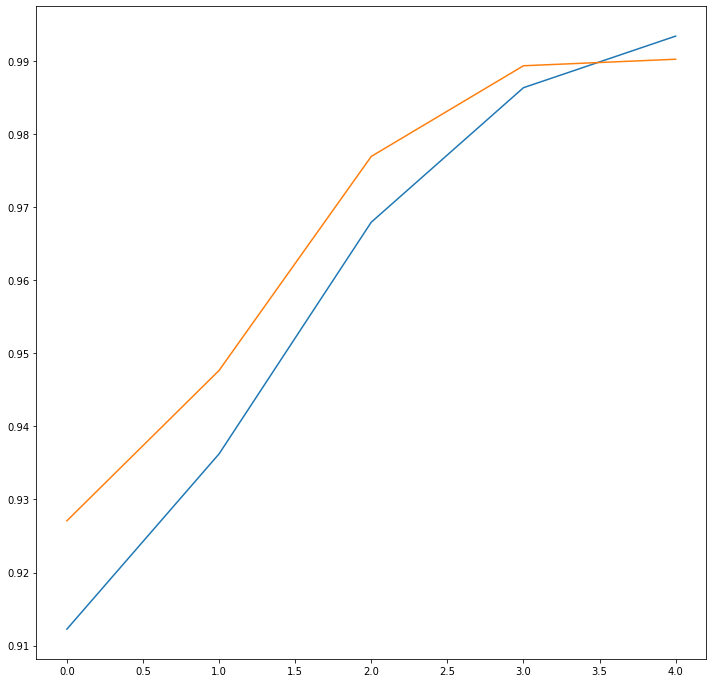

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])


Por último guardamos el modelo.

## Herarchical LSTM

En ocaciones no es posible ver todo el diccionario en el entrenamiento. Normalmente se tratan a palabras no vistas previamente como OOV (Fuera del vocabulario). Esto es práctico para idiomas como inglés. Pero no lo es tanto para otros idiomas con mucha riqueza morfológica, como turco. Es común encontrar en idiomas así palabras nuevas. Por ello, vamos a ver cómo comar en cuenta la información de sub palabra. Para ello vamos a codificar los caracteres con ayuda de un LSTM y concatenarlo con la información por palabra que ya tenemos.

Primero extraemos los caracteres y creamos diccionarios.

In [19]:
char_to_indx = {"PAD":0,"OOV":1, "BOS":2, "EOS":3}
indx_to_char = {0:"PAD",1:"OOV", 2:"BOS", 3:"EOS"}

chars = list()

for sent in train_sent:
    for word in sent:
        for c in word:
            chars.append(c)

chars = list(set(chars))

for c in chars:
    char_to_indx[c] = len(char_to_indx)

print(char_to_indx)

{'PAD': 0, 'OOV': 1, 'BOS': 2, 'EOS': 3, 'T': 4, 'I': 5, 'n': 6, 'b': 7, 'e': 8, '$': 9, 'G': 10, 'E': 11, 'j': 12, 'B': 13, ':': 14, 'y': 15, '8': 16, 't': 17, 'm': 18, 'Y': 19, 'x': 20, 'f': 21, '&': 22, 'C': 23, 'h': 24, 'W': 25, 'Z': 26, 'X': 27, '6': 28, '.': 29, '%': 30, "'": 31, '7': 32, '!': 33, 'H': 34, 'r': 35, 'z': 36, '0': 37, 'k': 38, '?': 39, 'L': 40, 'V': 41, 'Q': 42, '#': 43, 'q': 44, 'v': 45, 's': 46, 'c': 47, 'd': 48, '4': 49, 'g': 50, 'p': 51, 'O': 52, '`': 53, 'i': 54, 'M': 55, '@': 56, 'a': 57, 'o': 58, '1': 59, 'S': 60, 'A': 61, '*': 62, '2': 63, 'J': 64, 'l': 65, ',': 66, '9': 67, '3': 68, 'R': 69, '5': 70, 'N': 71, 'D': 72, 'U': 73, 'w': 74, 'u': 75, '/': 76, 'P': 77, ';': 78, 'K': 79, 'F': 80, '-': 81, '\\': 82}


Para luego codificar todos los ejemplos de entrenamiento en vectores de enteros. 

In [20]:
MAX_LEN_CHAR = 20

X_char_train = []
for sent in train_sent:
    sent_seq = []
    for i in range(MAX_LENGTH):
        word_seq = []
        for j in range(MAX_LEN_CHAR):
            try:
                word_seq.append(char_to_indx.get(sentence[i][0][j]))
            except:
                word_seq.append(char_to_indx.get("PAD"))
        sent_seq.append(word_seq)
    X_char_train.append(np.array(sent_seq))
    
X_char_dev = []
for sent in dev_sent:
    sent_seq = []
    for i in range(MAX_LENGTH):
        word_seq = []
        for j in range(MAX_LEN_CHAR):
            try:
                word_seq.append(char_to_indx.get(sentence[i][0][j]))
            except:
                word_seq.append(char_to_indx.get("PAD"))
        sent_seq.append(word_seq)
    X_char_dev.append(np.array(sent_seq))
    


print(X_char_dev[0])

[[ 4 35 54 ...  0  0  0]
 [46 57 54 ...  0  0  0]
 [37  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from tensorflow.keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Input

In [22]:
word_in = Input(shape=(MAX_LENGTH,))
emb_word = Embedding(input_dim=len(word_to_indx), output_dim=20,
                     input_length=MAX_LENGTH, mask_zero=True)(word_in)

char_in = Input(shape=(MAX_LENGTH, MAX_LEN_CHAR,))
emb_char = TimeDistributed(Embedding(input_dim=len(char_to_indx), output_dim=10,
                           input_length=MAX_LEN_CHAR, mask_zero=True))(char_in)

char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=100, return_sequences=True,
                               recurrent_dropout=0.1))(x)
out = TimeDistributed(Dense(len(tag_to_indx), activation="softmax"))(main_lstm)

model = Model([word_in, char_in], out)

W0628 06:35:07.902400 140735769576384 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0628 06:35:07.932744 140735769576384 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0628 06:35:07.969201 140735769576384 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0628 06:35:08.008182 140735769576384 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0628 06:35:08.221298 140735769576384 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Preparamos el modelo...

In [24]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 271, 20)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 271)]        0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 271, 20, 10)  830         input_3[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 271, 20)      206040      input_2[0][0]                    
____________________________________________________________________________________________

Entrenamos el modelo. Es tener en cuenta que nuestras dimensiones deben coincidir y por ellos tenemos los reshape.

In [32]:
print(np.array(X_char_train).shape)
print(np.array(train_X).shape)
print(np.array(train_Y).shape)

X_char_re = np.array(X_char_train).reshape(len(X_char_train), MAX_LENGTH, MAX_LEN_CHAR)
validation_data=[[dev_X, np.array(X_char_dev).reshape(len(X_char_dev), MAX_LENGTH, MAX_LEN_CHAR)], 
                    np.array(dev_Y).reshape(len(dev_X), MAX_LENGTH, 1)]

history = model.fit([train_X, X_char_re], 
                    np.array(train_Y).reshape(len(train_Y), MAX_LENGTH, 1),
                    batch_size=32, epochs=5, validation_data=validation_data, 
                    verbose=1)


(2817, 271, 20)
(2817, 271)
(2817, 271)
Train on 2817 samples, validate on 314 samples
Epoch 1/5
2817/2817 [==============================] - 75s 27ms/sample - loss: 0.0125 - acc: 0.9511 - val_loss: 0.0136 - val_acc: 0.9363
Epoch 2/5
2817/2817 [==============================] - 83s 29ms/sample - loss: 0.0091 - acc: 0.9636 - val_loss: 0.0122 - val_acc: 0.9389
Epoch 3/5
2817/2817 [==============================] - 79s 28ms/sample - loss: 0.0069 - acc: 0.9720 - val_loss: 0.0116 - val_acc: 0.9373
Epoch 4/5
2817/2817 [==============================] - 81s 29ms/sample - loss: 0.0059 - acc: 0.9752 - val_loss: 0.0112 - val_acc: 0.9429
Epoch 5/5
2817/2817 [==============================] - 83s 29ms/sample - loss: 0.0050 - acc: 0.9775 - val_loss: 0.0109 - val_acc: 0.9437


Mostramos los resultados. 

       loss       acc  val_loss   val_acc
0  0.012456  0.951106  0.013611  0.936336
1  0.009054  0.963592  0.012165  0.938939
2  0.006858  0.972044  0.011618  0.937337
3  0.005874  0.975166  0.011222  0.942943
4  0.005022  0.977467  0.010941  0.943744


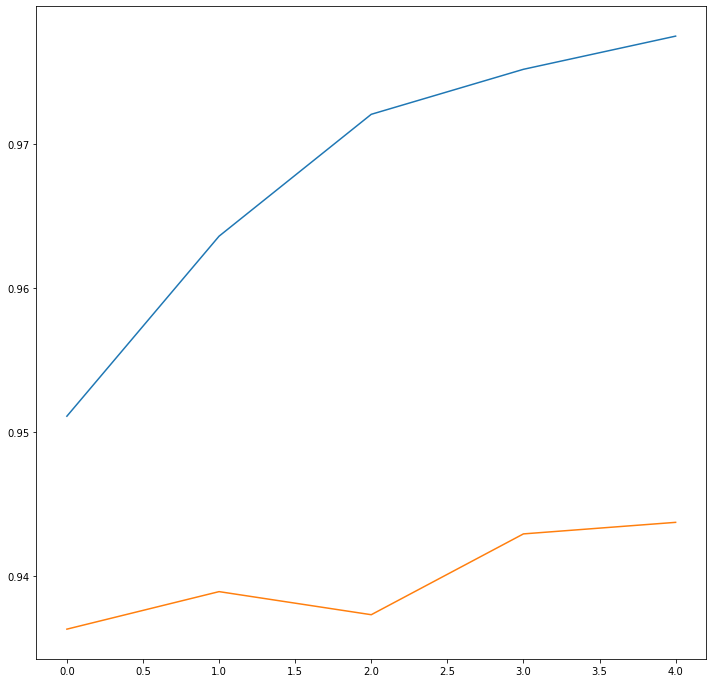

In [33]:
import pandas as pd

hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
print(hist)
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])


## Ejercicios

Cómo hemos visto las LSTM son muy poderosas para lograr procesar datos secuenciales. En este ejemplo vimos cómo inferir una clase por cada ejemplo de entrada y lo aplicamos para analizar la gramática de un enunciado.

El ejemplo que mostramos es clásico, pero: ¿Qué otras aplicaciones puede tener este tipo de clasificación?

* Encuentre otra aplicación y una base de datos para este modelo y utilicela para relizar predicciones.